# はじめに

- pytorchの練習も兼ねて，Canonical Correlation Analysis (正準相関分析)をpytorchを使って実装する．
- 本当は分散共分散行列からなる行列の一般化固有値問題を解くが，今回は勾配法で解を求める．
- pytorchのプログラムが間違っていないことを確認するためにscikit-learnでもやる．

## Canonical Correlation Analysis (正準相関分析)
[こちらの資料を参考にプログラムを書く．](https://www.jstage.jst.go.jp/article/jnns/20/2/20_62/_pdf)

主成分分析が多次元の値に対して，分散が大きい方向に射影するアルゴリズムなのに対して，正準相関分析では2つの多次元変数を射影先で相関が大きくなるように射影するアルゴリズムである．

多次元のデータ$x\in\mathbb{R}^{T\times K_x}$と$y\in\mathbb{R}^{T\times K_y}$間の正準相関を考える．
ここで$T$はデータ数(系列データのときはデータ長)，$K_x, K_y$は$x_i,y_i$の次元を表す．

$x$,$y$の射影ベクトルをそれぞれ$a\in\mathbb{R}^{K_x}$,$b\in\mathbb{R}^{K_y}$とする．
$x$,$y$の平均がそれぞれ0のとき，射影後の分散$S_{xx},S_{yy}$と共分散$S_{xy}$は，$S_{xx} = (a^\top x) (a^\top x)^\top=a^\top V_{xx}a$, $S_{yy} = (b^\top y) (b^\top y)^\top=b^\top V_{yy}b$，$S_{xy} = (a^\top x) (b^\top y)^\top=a^\top V_{xy}b$．

よって，射影後の相関$\rho$は$\rho = \frac{a^\top V_{xy}b}{\sqrt{a^\top V_{xx}a}\sqrt{b^\top V_{yy}b}}$になる．
ここで，$a$とか$b$を単純に$k$倍しても相関は変化しない．
最適化のときに解が複数あるのは面倒なので，制約条件$a^\top V_{xx}a = b^\top V_{yy}b = 1$を加える．

以上から以下を解くことで正準相関が求まる．
$\max_{a,b} a^\top V_{xy}b \ \mathrm{s.t.}\ a^\top V_{xx}a = b^\top V_{yy}b = 1$

これはラグランジュの未定乗数法で解くことができて，一般化固有値問題になるが，今回はこの式のまま勾配法で解く．

# 生成データでのテスト
以下のように適当に生成したデータを使って，正準相関分析のプログラムをテストする．

以下では
$x,y,\mathrm{dummy}\in\mathbb{R}^{200 \times 2}$の3つの信号を使う．
$x$,$y$はもともと同じ信号に大きめのノイズが乗ったもの．dummyは適当なノイズだけのもの．
$x$,$y$間では正準相関の値が大きくなり，$x$,dummy間では正準相関の値が小さくなってほしい．

In [1]:
import pylab as plt
import numpy as np
import torch 
from torch.autograd import Variable
import logging
import coloredlogs
from tqdm import tqdm

logger = logging.getLogger(__name__)
coloredlogs.install(
    #fmt="%(asctime)s %(levelname)s %(message)s"
    fmt="%(levelname)s %(message)s"
)

%matplotlib inline

logger.setLevel("DEBUG")
if logger.level >= logging.WARNING:
    tqdm = lambda x:x

In [2]:
u1 = np.r_[np.zeros(40), np.ones(30), np.ones(50)*2, np.ones(30), np.zeros(20), np.ones(30) ]
u2 = np.r_[np.ones(25), np.zeros(25), np.ones(25)*2, np.ones(55), np.zeros(35), np.ones(35) ]
u = np.c_[u1, u2]

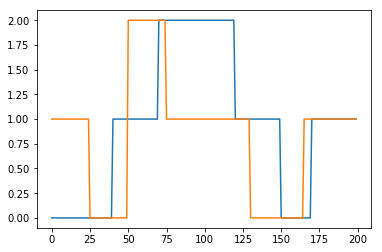

In [3]:
plt.plot(u)
plt.show()

In [4]:
sx = np.random.random(len(u)) * 10
sy = np.random.random(len(u)) * 10
sd = np.random.random(len(u)) * 10

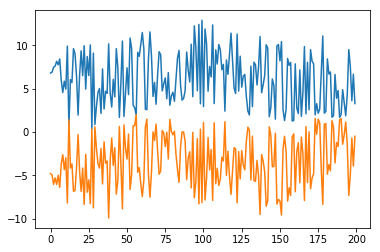

In [5]:
x = np.c_[
    u1 + sx + np.random.random(len(u)),
    u2 - sx + np.random.random(len(u)),   
]
plt.plot(x)
plt.show()

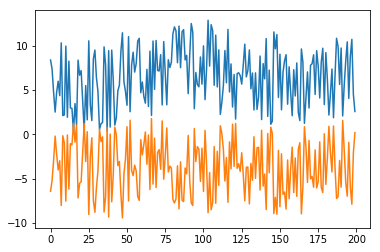

In [6]:
y = np.c_[
    u1 + sy + np.random.random(len(u)),
    u2 - sy + np.random.random(len(u)),   
]
plt.plot(y)
plt.show()

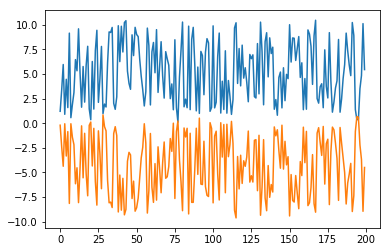

In [7]:
dummy = np.c_[
    sd + np.random.random(len(u)),
    -sd + np.random.random(len(u)),   
]
plt.plot(dummy)
plt.show()

以上のように，見た目では全部ぐちゃぐちゃなノイズにしか見えない3つの信号を生成した．

## Scikit-Learnによる実装
sciikit-learnには既に実装されているので，以下のように簡単に正準相関と射影後の変数を求めることができる．

In [8]:
from sklearn.cross_decomposition import CCA

In [9]:
cca = CCA(n_components=1)

0.906462806701


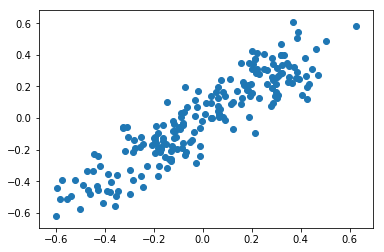

In [10]:
t_x, t_y = cca.fit_transform(x,y)
plt.scatter(t_x, t_y)
print(np.corrcoef(t_x.T, t_y.T )[0,1])
plt.show()

0.141422242479


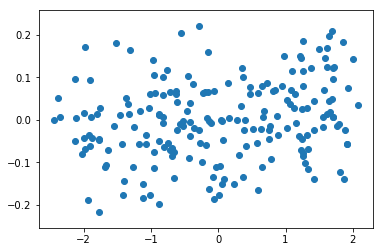

In [11]:
t_x, t_d = cca.fit_transform(x,dummy)
plt.scatter(t_x, t_d)
print(np.corrcoef(t_x.T, t_y.T )[0,1])
plt.show()

## PyTorchによる実装
pytorchにはtorch.eigという固有値を求める関数が用意されているので，これを頑張って使えば解けそうではある．
が，諸々の事情からペナルティ関数法で制約条件を加えた誤差関数を設定し，autogradで微分を求めて勾配法で解く．

元の最適化問題はこれだった．
$\max_{a,b} a^\top V_{xy}b \ \mathrm{s.t.}\ a^\top V_{xx}a = b^\top V_{yy}b = 1$

制約条件をペナルティ関数にして，以下のような誤差関数を最適化する．
$\mathrm{argmin}_{a,b} \mathcal{L} = -a^\top V_{xy}b + \gamma \left| 1 - a^\top V_{xx}a \right| + \gamma \left| 1 - b^\top V_{yy}b \right|$

$\gamma$は適当に0.5にした．小さい値だと制約があまり満たされず，逆に大きい値とかにするとうまく収束しないことが多い．この辺がよくわからないので，「機械学習のための連続最適化」という本を買ったけどまだ読めていない．

optimizerは何でもいいけど，単純にSGDにした．pytorch等で実装してると，なんとなくでoptimizerを選べるのでいいなと思う．

In [12]:
x -= np.mean(x, axis=0)
y -= np.mean(y, axis=0)
dummy -= np.mean(dummy, axis=0)
N = len(x)

def CCA(x,y,
        nb_steps = 100000,
        lr = 0.001,
        γ = 0.5):
    vxx = np.dot(x.transpose(), x)/N
    vyy = np.dot(y.transpose(), y)/N
    vxy = np.dot(x.transpose(), y)/N
    
    X = Variable(torch.from_numpy(x)).float()
    Y = Variable(torch.from_numpy(y)).float()
    
    a = Variable(torch.randn(2,1), requires_grad=True)
    b = Variable(torch.randn(2,1), requires_grad=True)
    
    Vxx = Variable(torch.from_numpy(vxx)).float()
    Vyy = Variable(torch.from_numpy(vyy)).float()
    Vxy = Variable(torch.from_numpy(vxy)).float()
    
    hist = []
    from torch import optim
    optimizer = optim.SGD([a, b], lr = 0.0001)

    for i in tqdm(range(nb_steps)):
        Loss = - torch.mm(torch.mm(torch.t(a), Vxy), b)  \
             + γ * torch.abs(1 - torch.mm(torch.mm(torch.t(a),Vxx),a))  \
             + γ * torch.abs(1 - torch.mm(torch.mm(torch.t(b),Vyy),b)) 
        hist.append(Loss.data.numpy()[0,0])
        optimizer.zero_grad()
        Loss.backward()
        optimizer.step()
        
    x_t = np.dot(a.data.numpy().transpose(), x.transpose())
    y_t = np.dot(b.data.numpy().transpose(), y.transpose())
    cca_score = torch.mm(torch.mm(torch.t(a), Vxy), b)
    
    logger.info("a Vxx a: %s"%torch.mm(torch.mm(torch.t(b),Vyy),b).data.numpy())
    logger.info("b Vyy b: %s"%torch.mm(torch.mm(torch.t(a),Vxx),a).data.numpy())
    return hist, x_t, y_t, cca_score

100%|██████████| 100000/100000 [00:19<00:00, 5232.01it/s]
INFO a Vxx a: [[ 1.00017715]]
INFO b Vyy b: [[ 1.00021267]]


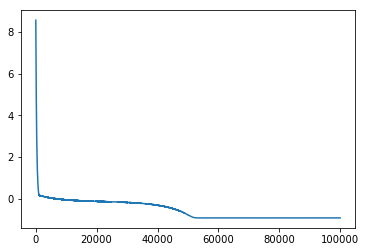

In [13]:
hist, x_t, y_t, cca_score = CCA(x,y)
plt.plot(hist)
plt.show()

Variable containing:
 0.9066
[torch.FloatTensor of size 1x1]



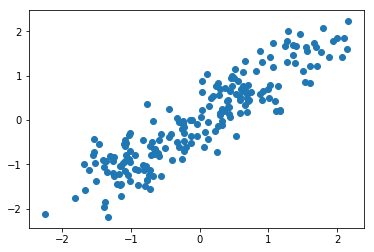

In [14]:
plt.scatter(x_t, y_t)
plt.show()
print(cca_score)

100%|██████████| 100000/100000 [00:19<00:00, 5199.69it/s]
INFO a Vxx a: [[ 1.00273335]]
INFO b Vyy b: [[ 0.99813366]]


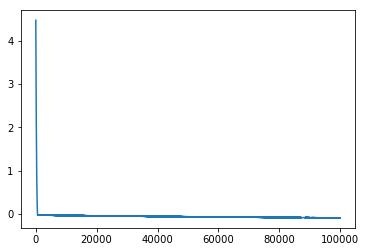

In [15]:
hist, x_t, y_t, cca_score = CCA(x,dummy)
plt.plot(hist)
plt.show()

Variable containing:
1.00000e-02 *
  9.6734
[torch.FloatTensor of size 1x1]

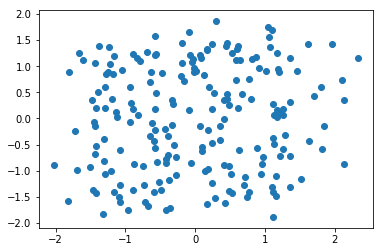

In [16]:
plt.scatter(x_t, y_t)
plt.show()
cca_score

無事にpytorchによる実装で，ある程度正しそうな結果を得ることができた．

# おわりに
pytorchで勾配法を使ったCCAの実装をやった．
制約付き最適化を勾配法で解く良いやり方がいまいちわかってないので，勉強したい．

# 参考
- [正準相関分析-複数種類の観測からの共通情報抽出-](https://www.jstage.jst.go.jp/article/jnns/20/2/20_62/_pdf)